### Telemetry Hello World

This is a very a brief introduction to Spark and Telemetry in Python. You should have a look at the [tutorial](https://gist.github.com/vitillo/25a20b7c8685c0c82422) in Scala and the associated [talk](http://www.slideshare.net/RobertoAgostinoVitil/spark-meets-telemetry) if you are interested to learn more about Spark.

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py

from moztelemetry import get_pings, get_pings_properties, get_one_ping_per_client

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Basics

The goal of this example is to plot the startup distribution for each OS. Let's see how many parallel workers we have at our disposal:

In [2]:
sc.defaultParallelism

16

Let's fetch 10% of Telemetry submissions for a given build-id...

In [4]:
pings = get_pings(sc, app="Firefox", channel="nightly", build_id=("20150520000000", "20150520999999"), fraction=0.1)

... and extract only the attributes we need from the Telemetry submissions:

In [5]:
subset = get_pings_properties(pings, ["clientId",
                                      "environment/system/os/name",
                                      "payload/simpleMeasurements/firstPaint"])

Let's filter out submissions with an invalid startup time:

In [6]:
subset = subset.filter(lambda p: p.get("payload/simpleMeasurements/firstPaint", -1) >= 0)

To prevent pseudoreplication, let's consider only a single submission for each client. As this step requires a distributed shuffle, it should always be run only after extracting the attributes of interest with *get_pings_properties*.

In [7]:
subset = get_one_ping_per_client(subset)

How many pings are we looking at?

In [8]:
subset.count()

1195

Let's group the startup timings by OS:

In [9]:
grouped = subset.map(lambda p: (p["environment/system/os/name"], p["payload/simpleMeasurements/firstPaint"])).groupByKey().collectAsMap()

And finally plot the data:

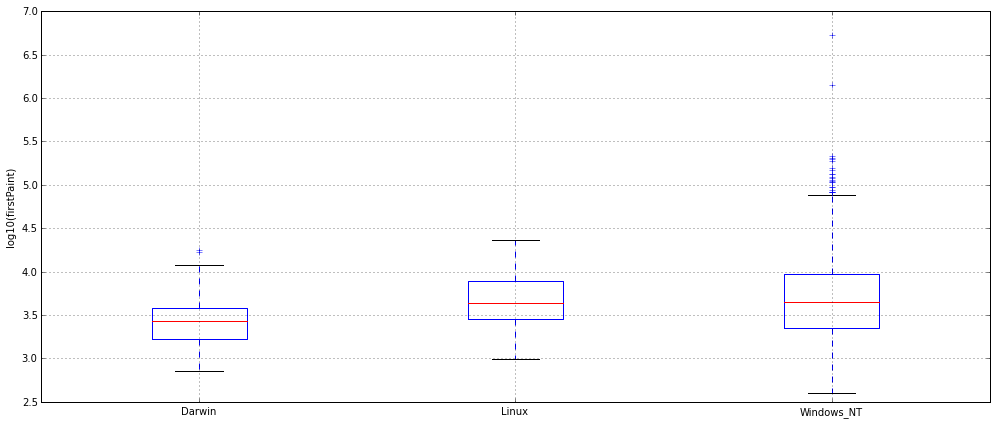

In [10]:
frame = pd.DataFrame({x: np.log10(pd.Series(list(y))) for x, y in grouped.items()})
plt.figure(figsize=(17, 7))
frame.boxplot(return_type="axes")
plt.ylabel("log10(firstPaint)")
plt.show()

###Histograms

Let's fetch some pings first:

In [12]:
pings = get_pings(sc, app="Firefox", channel="nightly", submission_date="20150426", fraction=0.1)

Let's extract a histogram from the submissions:

In [13]:
histograms = get_pings_properties(pings, "payload/histograms/GC_MARK_MS", with_processes=True)

The API returns three distinct histograms for each submission:
- a histogram for the parent process (*GC_MARK_MS_parent*)
- an aggregated histogram for the child processes (*GC_MARK_MS_children*)
- the aggregate of the parent and child histograms (*GC_MARK*)

Let's aggregate the histogram over all submissions and plot it:

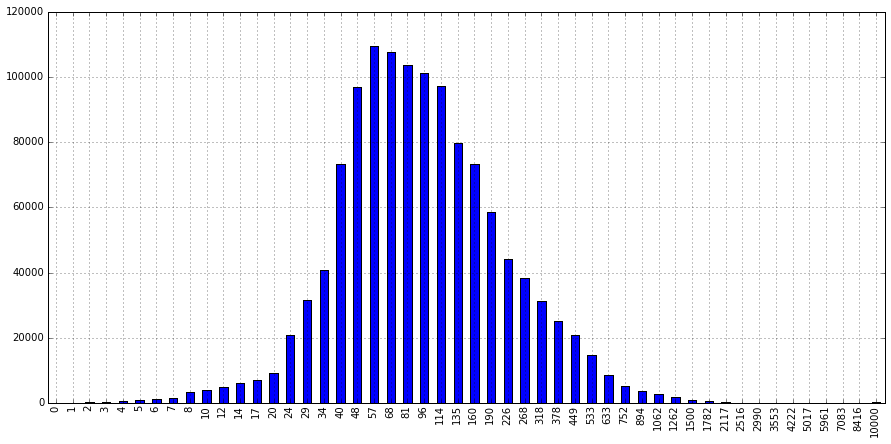

In [14]:
def aggregate_arrays(xs, ys):
    if xs is None:
        return ys
    
    if ys is None:
        return xs
    
    return xs + ys
    
aggregate = histograms.map(lambda p: p["payload/histograms/GC_MARK_MS"]).reduce(aggregate_arrays)
aggregate.plot(kind="bar", figsize=(15, 7))

#### Exercises

1) Plot the distribution of GC_MS faceted by OS. 